In [13]:
import sys
import os

# Addition of the scripts file
sys.path.append(os.path.abspath("scripts"))

# Import custom functions
from scripts.data_processing import load_data, preprocess_data
from scripts.eda import exploratory_data_analysis
from scripts.modelling import train_models
from scripts.evaluation import evaluate_models, predict_probabilities, robustness_check

# Load data
data_path = "data/DataDSVA_Python.xlsm"
df = load_data(data_path)

#Data cleaning and preprocessing
df_filtered = preprocess_data(df)

# **Introduction**

## **Objective**

Driving test success rates vary across test centers due to factors such as **infrastructure, traffic conditions, and examiner criteria**. This study aims to determine whether a candidate's likelihood of passing a driving test depends on their **test center choice**, along with other personal characteristics.

We focus on a candidate, **SIA**, a **22-year-old male**, and predict his probability of passing at two test centers:

-   **Bletchley** (a smaller town approximately 80 km from central London)
-   **Wood Green** (an urban neighborhood about 10 km north of central London)

These locations differ significantly in **traffic density** and **road infrastructure**, which are likely to influence driving test performance.

To model the probability of success, we employ **logistic regression**, considering the following key factors:

-   **Test center** (Bletchley vs. Wood Green)
-   **Candidate's age**
-   **Candidate's gender**
-   **Test year**

## **Research question**

> ***How do location, age, and gender affect the probability of passing a driving test?***

This question allows us to analyze the impact of demographic factors while also assessing whether certain test centers provide a statistically significant advantage.

## **Overview of data**

The data we use is a dataset from the **DVSA** which contains information on driving pass rates by age (17 to 25 years olds), gender, year (2007-2024) and test center. The data is organized into annual sheets in an Excel file, and for our analysis, we extract the relevant information specific to only Bletchley and Wood Green test centers.

# **Data exploration and preparation**

## **Dataset cleaning**

While cleaning the data, we notice that, fortunately for our friend SIA, both selected test centers, **Bletchley** and **Wood Green**, have a sufficient number of observations, with tests conducted for candidates aged **17 to 25** across multiple years. This ensures a robust dataset for analysis.

After filtering for relevant locations and years, the final dataset contains **306 rows**, capturing **9 age groups per center per year** over **18 years**. Data extraction was performed in **R**, using a **for loop** to systematically retrieve relevant data from each annual sheet and compile it into a structured data frame (**df**).

Later inour analysis, the data was then transformed from **wide to long format**, ensuring that each row represents passing characteristics separately for **males and females**. To prepare for logistic regression, we converted character variables to **numeric** where necessary. The **Location** variable was transformed into a **binary indicator** (1 for Bletchley, 0 for Wood Green) for clarity in the regression model. Similarly, the **Gender** variable was encoded as **1 for Male and 0 for Female**.

**Descriptive statistics**
         Location         Age  Conducted_Male  Passes_Male  PassRate_Male  \
count  306.000000  306.000000      306.000000   306.000000     306.000000   
mean     0.500000   21.000000      244.826797   120.271242      48.423898   
std      0.500819    2.586218      171.307257    93.654448       5.566467   
min      0.000000   17.000000       30.000000    13.000000      33.333333   
25%      0.000000   19.000000      141.000000    69.000000      44.278160   
50%      0.500000   21.000000      190.000000    89.500000      47.941995   
75%      1.000000   23.000000      279.000000   130.750000      52.440857   
max      1.000000   25.000000      927.000000   570.000000      64.102564   

       Conducted_Female  Passes_Female  PassRate_Female  Conducted_Total  \
count        306.000000     306.000000       306.000000       306.000000   
mean         241.454248     108.098039        43.785887       486.281046   
std          148.478379      81.177705         6.66

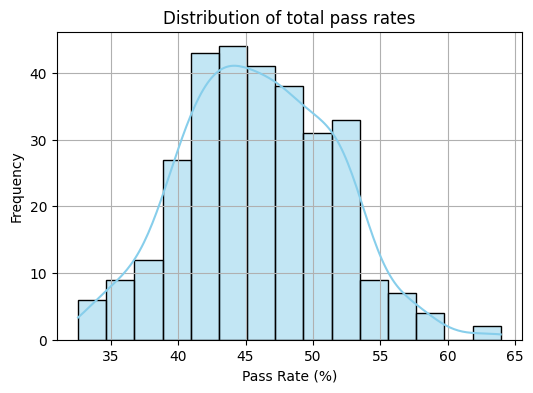

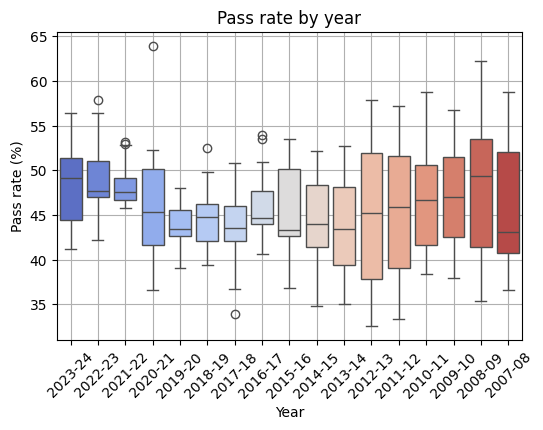

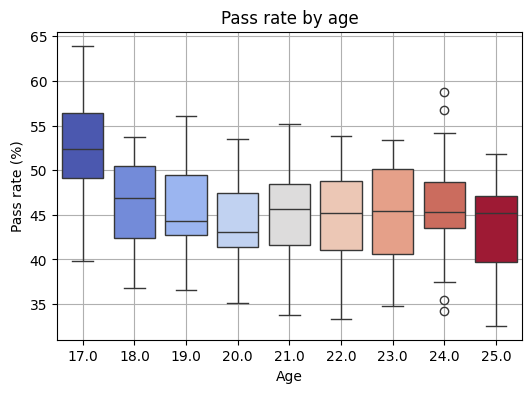

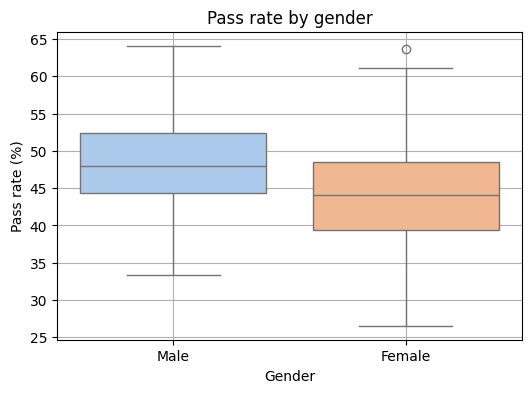

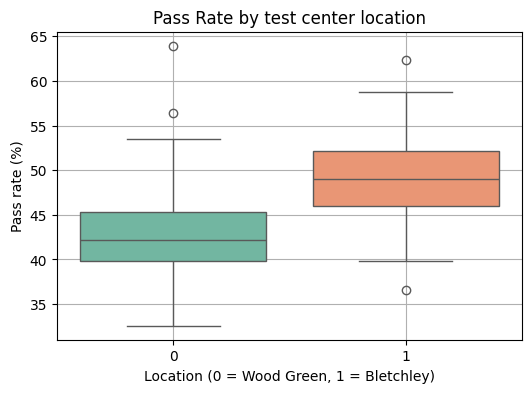

coucou


In [ ]:
# Exploratory Data Analysis
exploratory_data_analysis(df)

### **Summary statistics**
On the **summary statistics** table, We can see that the dataset contains **306 observations** across **12 variables**, covering **test location, candidate age, number of tests conducted and passed (by gender), pass rates, and year**.

-   **No missing values** are present thanks to our data cleaning.
-   The **mean pass rate** is **45.95%**, with values ranging from **32.58% to 63.93%**.
-   The number of tests conducted varies significantly, with some centers conducting as few as **61 tests** while others exceed **1,699 tests**.
-   While the number of tests taken by **males and females differs**, their **pass rates remain relatively similar** on average.

### **Distribution of key variables**
To better understand the **distribution of pass rates**, we also generated a **histogram and boxplot**. The **histogram** reveals a right-skewed distribution, with most pass rates concentrated between **35% and 55%**, and a few high outliers exceeding **60%**. 

### **Trends in pass rates by Location, Gender, Age, and Year**

The findings are as follows:

-   **Location**: Pass rates are generally **higher in Bletchley** than in Wood Green.
-   **Gender**: **Males** exhibit slightly **higher average pass rates** than females.
-   **Age**: Pass rates peak at **age 17**, remain relatively stable, but tend to **decline for older candidates**.
-   **Year**: **Pass rates remained stable** from **2007 to 2020**, but show **an increase post-2021**, likely due to **COVID-related changes in testing conditions**.

Given this shift, we **restrict further analysis to post-2021 data** to focus on more stable and comparable conditions. This ensures that external disruptions do not skew our findings. (done in data preprocessing)
As a result, ‘Year’ is no longer included as a predictor since we aggregate test outcomes by location, gender, and age. This transformation ensures a consistent structure for regression analysis

## **Variable selection**

To analyze the expected passing rate at Bletchley and Wood Green for our candidate, SIA, we employ a **logistic regression model**. This allows us to estimate the probability of passing based on key individual and contextual factors.

### **Dependent and independent variables**

Using our cleaned dataset **(df_filtered)**, we define the variables as follows:

-   **Dependent variable**: A **binary outcome** indicating whether a candidate passed (Passes) or failed (Failures). These two columns are used to construct a binomial response, which is compatible with logistic regression in Python via statsmodels.GLM().
-   **Independent variables**:
    -   **Location**: Categorical variable distinguishing between **Bletchley (1)** and **Wood Green (0)**.
    -   **Gender**: Binary variable where **male = 1** and **female = 0**.
    -   **Age**: A continuous variable, treated numerically to capture the effect of each additional year on pass probability.

All variables were cleaned and encoded during the preprocessing step, ensuring compatibility with the logistic and probit models used in the training phase.

### **Why a logistic regression?**

Unlike linear regression, which models continuous outcomes, **logistic regression** is appropriate for **binary outcomes**, as it constrains predictions to values between **0 and 1**. The logistic function transforms a linear combination of predictors into a probability using the following equation:

$$
P(Y = 1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}}
$$

where: - $P(Y=1)$ represents the probability of passing, - $X_1, X_2, ..., X_n$ are the independent variables, - $\beta_0, \beta_1, ..., \beta_n$ are the estimated coefficients.

This equation refers to an S-shaped curve that converts any real value to a range between 0 and 1. Figure aids in visualising the difference between a linear model and logistic model.

![Linear vs Logistic Model](assets/Linear%20vs%20Logistic%20Model.png)

To facilitate interpretation, we also consider the **logit transformation**, the inverse of the logistic function, which expresses the probability in **log-odds form**:

$$
\log \left( \frac{P(Y = 1)}{1 - P(Y = 1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_n X_n
$$

This transformation linearizes the relationship, allowing us to assess how changes in each predictor affect the odds of passing.

### **Implications for our interpretation**

Since our dependent variable is binary, estimated coefficients represent **log-odds** and must be exponentiated to derive **odds ratios**. For example:

-   A **positive coefficient** suggests an **increase** in the likelihood of passing.
-   A **negative coefficient** implies a **decrease** in the likelihood of passing.

By leveraging logistic regression, we can quantify the effect of **test center location, age, and gender** on driving test outcomes, providing a robust statistical framework to guide SIA’s decision.

# **Regression model specification & analysis**

## **Model specification**

We estimate the model using the statsmodels implementation of a binomial Generalized Linear Model (GLM) with a logit link. The logistic regression equation is:
$$
\log \left( \frac{P(\text{Pass} = 1)}{1 - P(\text{Pass} = 1)} \right) = \beta_0 + \beta_1 \text{Location} + \beta_2 \text{Gender} + \beta_3 \text{Age}
$$


where:

-   **Pass** is the binary dependent variable (1 if the individual passed, 0 otherwise).
-   **Location** is an indicator for the test center (1 = Bletchley, 0 = Wood Green).
-   **Gender** is a binary variable (1 = Male, 0 = Female).
-   **Age** represents the candidate's age.

The probability of passing is derived from the logistic function:

$$
P(\text{Pass} = 1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 \text{Bletchley} + \beta_2 \text{Male} + \beta_3 \text{Age})}}
$$

Unlike **OLS regression**, the usual assumptions of **normally distributed residuals and homoscedasticity** do not hold in logistic regression. Since our outcome is binary, residuals are not normally distributed, and variance depends on the predicted probabilities rather than remaining constant.

# **Logistic regression estimation**

## **Estimation results**

The results of the logistic and probit regression are shown below. 
The coefficient for **Bletchley (0.148, p < 0.001)** indicates that candidates at this test center have higher odds of passing than those in Wood Green. **Gender (0.0839, p < 0.001)** shows that males have a significantly higher probability of success compared to females. **Age coefficients are all negative and highly significant (-0.0302, p < 0.001)**, confirming that older candidates tend to have lower pass rates.
Model fit statistics support this conclusion:

- The **pseudo R² is 0.63**, indicating that a large proportion of variation in test outcomes is explained by the model.

- The **log-likelihood (-381.15)** and **AIC (approx. 768)** are within expected ranges for a model of this size and dataset.

- All coefficients **are statistically significant** at the 1% level, reinforcing the reliability of the results.

In addition, we computed the **ROC curve**, which produced an **AUC of 0.77**, confirming that the model has strong classification power in distinguishing between candidates who are likely to pass vs. fail.

The **probit model** yielded very similar results, supporting the robustness of the effects observed in the logistic model.

## **Discussion of the zero conditional mean assumption**

To ensure unbiased estimates, the **zero conditional mean assumption** (i.e., that the error term is uncorrelated with the explanatory variables) is considered. Here’s how we evaluate it:
-   **Omitted variable bias**: While our model controls for key predictors (location, gender, age), unobserved factors such as **driving instructor quality** or **test difficulty variation** may still introduce bias. However, including age and gender mitigates some of this risk.
-   **Measurement errors**: The data is sourced from **official DVSA records**, minimizing concerns related to self-reporting errors or misclassification.
-   **Reverse causality**: Unlike economic or behavioral studies where the dependent variable might influence explanatory variables, there is **no risk of reverse causality** here, as test outcomes do not determine gender, age, or test location.
-   **External validation**: These findings are in line with **existing research** on driving test pass rates, where **younger male candidates** and certain test centers consistently show higher pass rates, lending credibility to our model’s structure.

Logit regression summary :
                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Passes', 'Failures']   No. Observations:                  108
Model:                                GLM   Df Residuals:                      104
Model Family:                    Binomial   Df Model:                            3
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -381.15
Date:                    Wed, 26 Mar 2025   Deviance:                       124.65
Time:                            14:27:53   Pearson chi2:                     124.
No. Iterations:                         3   Pseudo R-squ. (CS):             0.6320
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

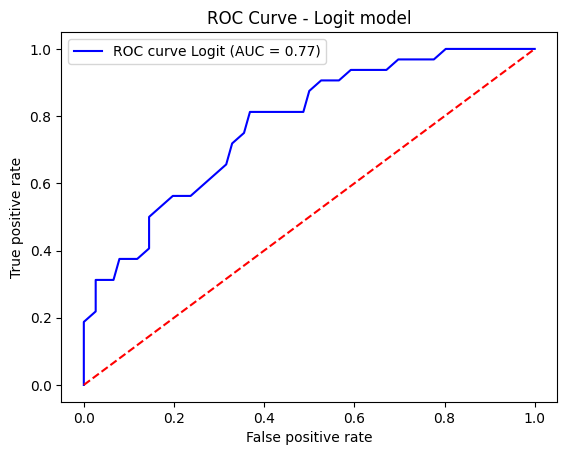

In [7]:
# Model training and evaluation
logit_model, probit_model = train_models(df_filtered)
evaluate_models(logit_model, probit_model, df_filtered)

# **Model diagnostics and robustness checks**

To further test the reliability of our model, we performed a robustness check by re-estimating the logistic regression on a random 80% subsample of the data.

The comparison between the original and re-estimated coefficients shows minimal variation, confirming that the model is **stable and not overly sensitive to the sample used.**

This strengthens the conclusion that **location, gender, and age** are consistently associated with differences in driving test outcomes, even across different subsets of the data.

In [8]:
# Model evaluation and robustness
robustness_check(df_filtered, logit_model)

**Robustness test**
Coefficient comparison (original vs re-estimated):
          Original  Re-estimated
const     0.447513      0.552362
Location  0.147979      0.123951
Gender    0.083923      0.100353
Age      -0.030242     -0.035338


## **Predictions**
### **SIA' predicted probabilities (male, 22-year-old)**

Using our logistic regression model trained in Python with `statsmodels`, we predicted the probability of passing the driving test for different profiles, based on **location**, **gender**, and **age**.

We created a small test set with combinations of interest (e.g. male/female at Bletchley or Wood Green, aged 22), and used the `.predict()` method to estimate probabilities.

Here are the results:

- **22-year-old male**:
  - **Bletchley**: 50.35%
  - **Wood Green**: 46.66%

### **Bonus : 22-year-old female predicted probabilities**

- **22-year-old female**:
  - **Bletchley**: 48.25%
  - **Wood Green**: 44.58%

This confirms that:
- **Bletchley** offers a higher chance of passing than Wood Green.
- **Males** have slightly higher odds than females.
- **Older candidates** are less likely to pass, all else equal.

The predictions align closely with the estimated coefficients and provide an intuitive way to interpret model outputs in real-world scenarios.

In [6]:
# Make predictions
predict_probabilities(logit_model)

**Probability predictions**
Probability of passing for a 22.0-year-old Male at Bletchley: 50.35%
Probability of passing for a 22.0-year-old Male at Wood Green: 46.66%
Probability of passing for a 22.0-year-old Female at Bletchley: 48.25%
Probability of passing for a 22.0-year-old Female at Wood Green: 44.58%


# **Conclusion and limitations**

## **Summary of findings**

This analysis explored how **test center**, **gender**, and **age** influence the probability of passing the UK driving test, using a **logistic regression model in Python**.

Our findings show:

- Candidates at **Bletchley** have significantly higher odds of success than at Wood Green (**p < 0.001**).
- **Males** are more likely to pass than females.
- **Pass rates decrease with age**, with age coefficients negative and statistically significant.

A **22-year-old male** is estimated to have a **50.35%** chance of passing at Bletchley vs. **46.66%** at Wood Green, a meaningful **3.7 percentage point advantage**. The model’s ROC curve (**AUC = 0.77**) confirms **good predictive power**, and robustness checks show **stable coefficients across samples**.


## **Limitations and further research**

Despite its predictive strength, our analysis has several **limitations**. The dataset is **aggregated**, lacking individual-level information on factors such as **training hours, prior driving experience, or specific test conditions (e.g., weather, roadworks, or time of day)**, which could significantly influence pass rates. Additionally, we **cannot account for differences in examiner leniency or driving instruction quality**, which may systematically vary between locations.

Another limitation is the **use of driver license numbers**, which may introduce **duplicates** if candidates retake the test after a failed attempt. As explained in the notes of the ’dvsa1203’ file, changes to license numbers can result in the same individual being counted multiple times, inflating the number of unique observations.This could bias the results, particularly if **retest likelihood is correlated with candidate characteristics such as age or location**.

## **Reflection and future directions**

A key assumption of our model is the **zero conditional mean assumption (E[u\|X] = 0)**, which requires that **unobserved factors affecting pass rates are uncorrelated with the included predictors**. While we control for major observable characteristics, unaccounted factors like **traffic conditions, test scheduling, or previous training experiences** could still introduce bias.

Future research could improve this analysis by incorporating **individual-level microdata**, including **training history, test timing, and weather conditions**. Additionally, using **panel data with unique candidate identifiers** would allow tracking of test performance over multiple attempts, reducing the risk of **duplicate observations and omitted variable bias**. These refinements would provide a **more nuanced understanding** of the determinants of driving test success, enabling better policy recommendations for improving pass rates.